# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)


. [Correlations](#correlations)


In [6]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pip install ucimlrepo


Note: you may need to restart the kernel to use updated packages.


## Dataset Overview

[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


## Attention: currently commented out since there is better way as shown in the next code snippet.

In [ ]:
# comment out the following lines


# change directory to the location of the dataset file CTG.xls

#%cd '/workspaces/Tensor-flow-project'

# Install xlrd package
#%pip install xlrd

# Replace 'your_dataset.csv' with the path to your actual dataset
#df = pd.read_excel('CTG.xls', sheet_name='Data')

# Number of samples
#num_samples = df.shape[0]

# Number of features
#num_features = df.shape[1]

# Display these dataset characteristics
#print(f"Number of samples: {num_samples}")
#print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
#print("Example data:")
#print(df.head())





/workspaces/Tensor-flow-project
Note: you may need to restart the kernel to use updated packages.
Number of samples: 2130
Number of features: 46
Example data:
  Unnamed: 0 Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5  \
0          b          e         AC         FM         UC         DL   
1        240        357          0          0          0          0   
2          5        632          4          0          4          2   
3        177        779          2          0          5          2   
4        411       1192          2          0          6          2   

  Unnamed: 6 Unnamed: 7 Unnamed: 8  Unnamed: 9  ... Unnamed: 36 Unnamed: 37  \
0         DS         DP         DR         NaN  ...           E          AD   
1          0          0          0         NaN  ...          -1          -1   
2          0          0          0         NaN  ...          -1           1   
3          0          0          0         NaN  ...          -1           1   
4          0       

## A more convenient option is to use the "fetch_ucirep" option.

In [16]:
import pandas as pd

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
df = fetch_ucirepo(id=193) 
  
# data (as pandas dataframes) 
X = df.data.features 
y = df.data.targets 
  
# metadata 
print(df.metadata) 
  
# variable information 
print(df.variables) 

#print number of samples and features
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")


# Display the first few rows of the dataframe to show the structure
print(f"Example data: {X.head()}")




{'uci_id': 193, 'name': 'Cardiotocography', 'repository_url': 'https://archive.ics.uci.edu/dataset/193/cardiotocography', 'data_url': 'https://archive.ics.uci.edu/static/public/193/data.csv', 'abstract': 'The dataset consists of measurements of fetal heart rate (FHR) and uterine contraction (UC) features on cardiotocograms classified by expert obstetricians.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 2126, 'num_features': 21, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['CLASS', 'NSP'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2000, 'last_updated': 'Fri Mar 15 2024', 'dataset_doi': '10.24432/C51S4N', 'creators': ['D. Campos', 'J. Bernardes'], 'intro_paper': None, 'additional_info': {'summary': '2126 fetal cardiotocograms (CTGs) were automatically processed and the respective diagnostic features measured. The CTGs were also classified

## Handling Missing Values

[Identify any missing values in the dataset, and describe your approach to handle them if there are any. If there are no missing values simply indicate that there are none.]


In [20]:
# Check for missing values
missing_values_X = X.isnull().sum()
missing_values_y = y.isnull().sum()
missing_values_X
missing_values_y


CLASS    0
NSP      0
dtype: int64

In [ ]:
# Handling missing values
# Example: Replacing NaN values with the mean value of the column
# df.fillna(df.mean(), inplace=True)

# Your code for handling missing values goes here


## Feature Distributions

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]


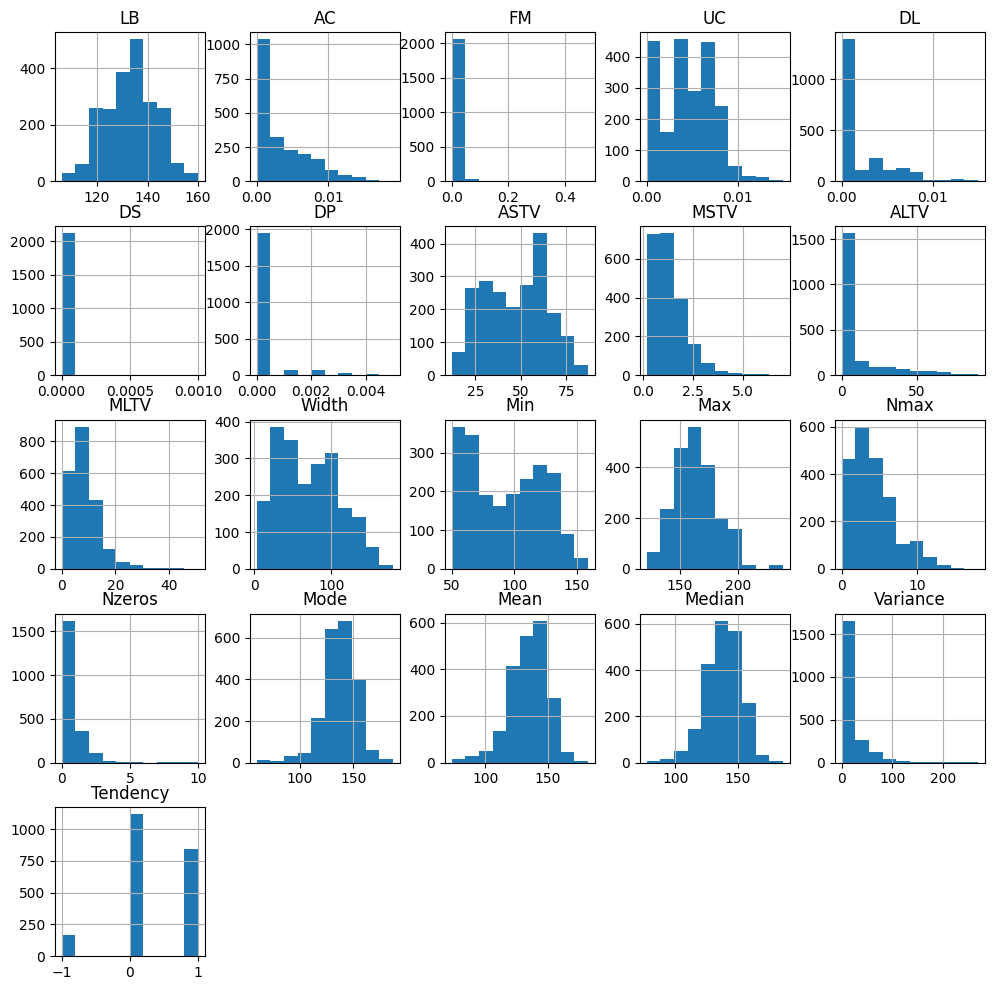

In [21]:
# Example: Plotting histograms of all numerical features
X.hist(figsize=(12, 12))
plt.show()


## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


In [ ]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)

# Your code to investigate possible biases goes here


## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]


In [ ]:
# Example: Plotting a heatmap to show feature correlations
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()
